In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torchvision.utils import make_grid
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

#we set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

def show_tensor_images(image_tensor, num_images=25, size=(3, 64, 64)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

Random Seed:  999


In [2]:
# Root directory for dataset
dataroot = "../input/celeba-dataset"
# Number of workers for dataloader
workers = 2
batch_size = 128
image_size = 64
nc = 3
# Size of z latent vector 
nz = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# Number of training epochs
num_epochs = 8

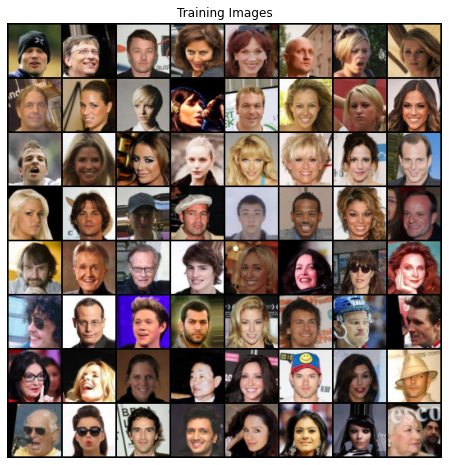

In [3]:
# Creating the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# here we set the device as cuda if it is avaliable
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8,kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4, kernel_size=4, stride=2,padding=1),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=2,padding=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim, kernel_size=4, stride=2,padding=1),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, stride=2,padding=1, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2,padding=0, final_layer=False):
        
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels,output_channels,kernel_size,stride,padding,bias=False),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
                
                
            )
        else: # Final Layer
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels,output_channels,kernel_size,stride,padding,bias=False),
                nn.Tanh()
            )

    def forward(self, noise):
        return self.gen(noise)

In [5]:
gen=Generator()
print(gen)

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [6]:
class Discriminator(nn.Module):
    def __init__(self, im_chan=3, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim,kernel_size=4, stride=2,padding=1,bn=False),#13
            self.make_disc_block(hidden_dim, hidden_dim * 2,kernel_size=4, stride=2,padding=1),#6
            self.make_disc_block(hidden_dim*2, hidden_dim * 4,kernel_size=4, stride=2,padding=1),#3
            self.make_disc_block(hidden_dim*4, hidden_dim * 8,kernel_size=4, stride=2,padding=1),
            self.make_disc_block(hidden_dim * 8, 1,kernel_size=4, stride=1,padding=0, final_layer=True),
        )
    
    def make_disc_block(self, input_channels, output_channels, kernel_size=3, stride=2,padding=0,bias=False, final_layer=False,bn=True):
        if not final_layer:
            if bn:
                return nn.Sequential(
                    nn.Conv2d(input_channels,output_channels,kernel_size,stride,padding, bias=False),
                    nn.BatchNorm2d(output_channels),
                    nn.LeakyReLU(0.2,inplace=True),
            )
            else:
                return nn.Sequential(
                    nn.Conv2d(input_channels,output_channels,kernel_size,stride,padding, bias=False),
                    nn.LeakyReLU(0.2,inplace=True),)
        else: # Final Layer
            return nn.Sequential(
                nn.Conv2d(input_channels,output_channels,kernel_size,stride,padding, bias=False),
                nn.Sigmoid()
            )

    def forward(self, image):
        return self.disc(image)

In [7]:
dis=Discriminator()
print(dis)

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )

In [8]:
#new
criterion = nn.BCELoss()
z_dim = 100
display_step = 500
batch_size = 128
lr = 0.0002

beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'
fixed_noise = torch.randn(64, nz, 1, 1, device=device)#for displaying

gen = Generator().to(device)
optimizerG = optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device)
optimizerD = optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen.apply(weights_init)
disc.apply(weights_init)

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )

[0/8][0/1583]	Loss_D: 1.9507	Loss_G: 4.6704	D(x): 0.9562	D(G(z)): 0.5543 / 0.0162
[0/8][1500/1583]	Loss_D: 1.6156	Loss_G: 3.0848	D(x): 0.9292	D(G(z)): 0.4968 / 0.0640


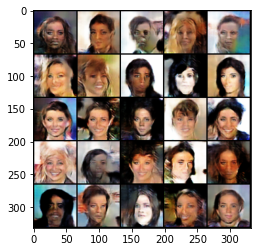

[1/8][0/1583]	Loss_D: 0.5798	Loss_G: 2.2132	D(x): 0.7816	D(G(z)): 0.2377 / 0.1335


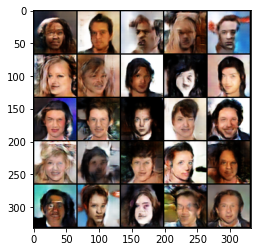

[1/8][1500/1583]	Loss_D: 0.7275	Loss_G: 2.9669	D(x): 0.8557	D(G(z)): 0.2865 / 0.0635
[2/8][0/1583]	Loss_D: 0.0130	Loss_G: 0.9643	D(x): 0.0990	D(G(z)): 0.0065 / 0.4564


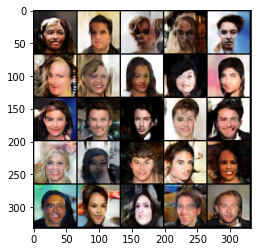

[2/8][1500/1583]	Loss_D: 0.8508	Loss_G: 1.5311	D(x): 0.6468	D(G(z)): 0.3130 / 0.2960
[3/8][0/1583]	Loss_D: 0.8528	Loss_G: 2.3977	D(x): 0.7902	D(G(z)): 0.3170 / 0.1211


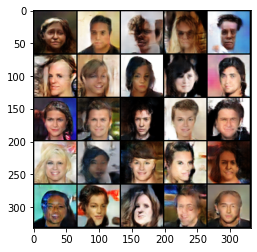

[3/8][1500/1583]	Loss_D: 0.1942	Loss_G: 2.6118	D(x): 0.6851	D(G(z)): 0.0872 / 0.0998
[4/8][0/1583]	Loss_D: 0.3783	Loss_G: 0.7851	D(x): 0.5758	D(G(z)): 0.1578 / 0.5017


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f74527ab170>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f74527ab170>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

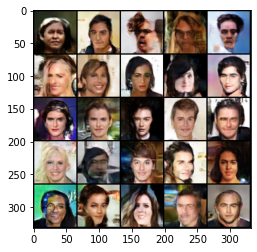

[4/8][1500/1583]	Loss_D: 0.4101	Loss_G: 2.3585	D(x): 0.7829	D(G(z)): 0.1740 / 0.1214
[5/8][0/1583]	Loss_D: 0.9726	Loss_G: 2.7124	D(x): 0.7269	D(G(z)): 0.3383 / 0.0946


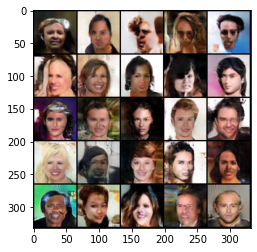

[5/8][1500/1583]	Loss_D: 0.2203	Loss_G: 0.6656	D(x): 0.3715	D(G(z)): 0.0987 / 0.5608
[6/8][0/1583]	Loss_D: 0.3559	Loss_G: 3.3921	D(x): 0.9312	D(G(z)): 0.1557 / 0.0463


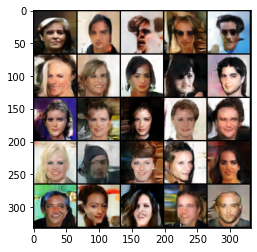

[6/8][1500/1583]	Loss_D: 0.7600	Loss_G: 3.8468	D(x): 0.9187	D(G(z)): 0.2903 / 0.0319
[7/8][0/1583]	Loss_D: 0.4667	Loss_G: 3.2173	D(x): 0.8642	D(G(z)): 0.1921 / 0.0565


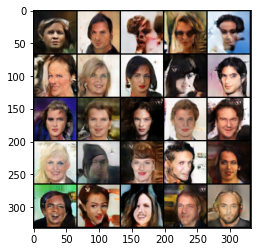

[7/8][1500/1583]	Loss_D: 0.0807	Loss_G: 2.8061	D(x): 0.7773	D(G(z)): 0.0386 / 0.0917


In [11]:
img_list = []
G_losses = []
D_losses = []
iters = 0
display_step=1500
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        disc.zero_grad()
        # Format batch
        real = data[0].to(device)
        b_size = real.size(0)
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        #print(noise.shape)
        fake = gen(noise)
        output = disc(fake.detach()).view(-1)
        Disc_fake_loss = criterion(output, torch.zeros_like(output))
        Disc_fake_loss.backward()
        D_G_z1 = output.mean().item()
        
        
        # Forward pass real batch through Discriminator
        output = disc(real).view(-1)
        Disc_real_loss = criterion(output, torch.ones_like(output))
        Disc_real_loss.backward()
        D_x = output.mean().item()
        
        # Compute error of Discriminator as sum over the fake and the real batches
        Disc_error = Disc_fake_loss + Disc_fake_loss
        # Update Discriminator 
        optimizerD.step()
        
        #Update generator
        gen.zero_grad()
        output = disc(fake).view(-1)
        # Calculate Generator's loss based on this output
        Gen_fake_loss = criterion(output,  torch.ones_like(output))
        # Calculate gradients for Generator
        
        Gen_fake_loss.backward()
        D_G_z2 = output.mean().item()
        # Update Generator
        optimizerG.step()
        # Output training stats
        if i % 1500 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     Disc_error.item(), Gen_fake_loss.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(Gen_fake_loss.item())
        D_losses.append(Disc_error.item())

        # Check how the generator is doing by saving Generator's output on fixed_noise
        if iters % display_step == 0 and iters > 0:
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            show_tensor_images(fake)
            
        iters += 1

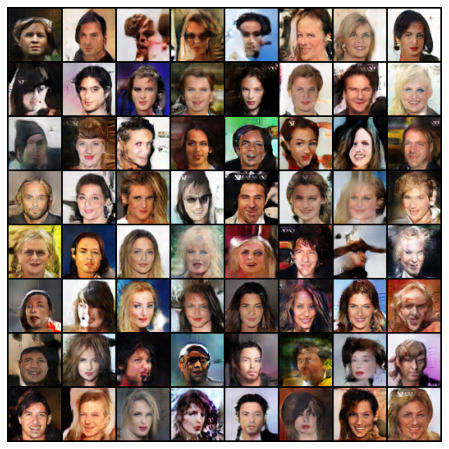

In [12]:

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

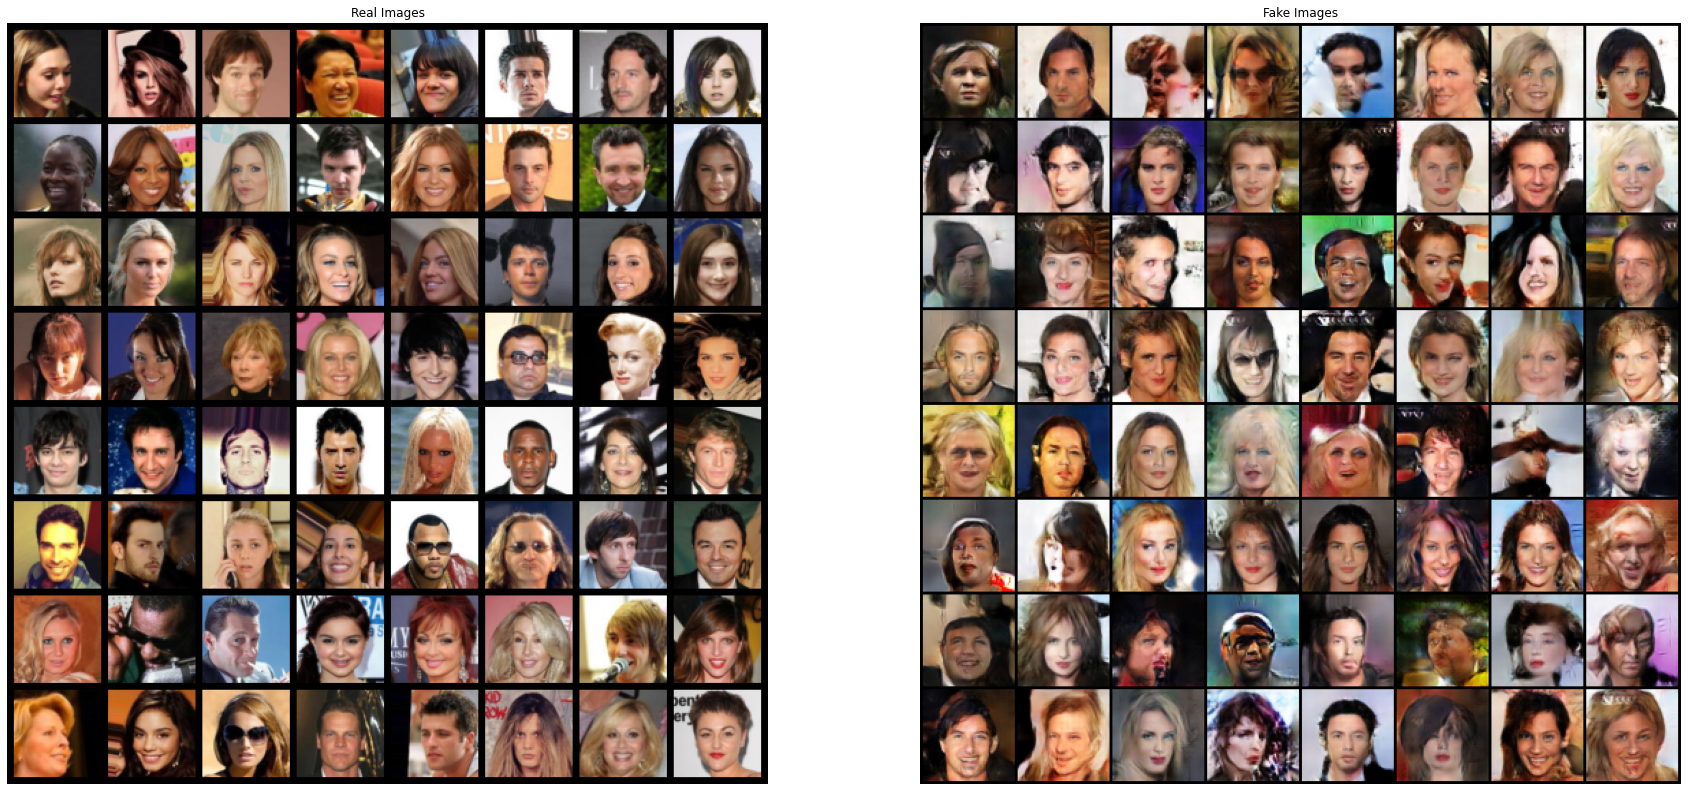

In [13]:
# Take a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(30,30))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

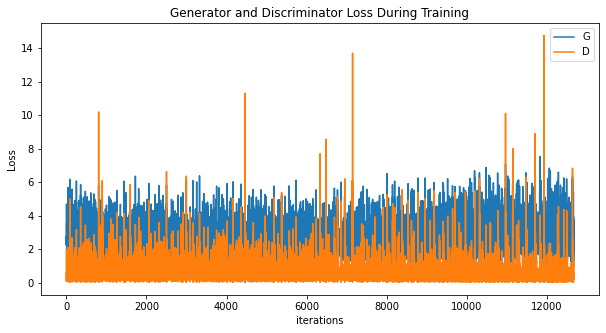

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()